<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#BoB-ASIRI-2013-CTD-χpod" data-toc-modified-id="BoB-ASIRI-2013-CTD-χpod-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>BoB ASIRI 2013 CTD χpod</a></span><ul class="toc-item"><li><span><a href="#Read-in-turbulence-data" data-toc-modified-id="Read-in-turbulence-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read in turbulence data</a></span></li></ul></li><li><span><a href="#Read-in-gradients" data-toc-modified-id="Read-in-gradients-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read in gradients</a></span></li></ul></div>

# BoB ASIRI 2013 CTD χpod

This notebook will attempt to infer eddy diffusivity $K_e$ from the basin-wide transect of $χ, K_T$

## Read in turbulence data

and convert to xarray

In [1]:
import sys
sys.path.append('../eddydiff/')

# load data
import scipy.io

tr1 = sp.io.loadmat('../datasets/bob-ctd-chipod/transect_1.mat', squeeze_me=True)
tr2 = sp.io.loadmat('../datasets/bob-ctd-chipod/transect_2.mat', squeeze_me=True)
tr3 = sp.io.loadmat('../datasets/bob-ctd-chipod/transect_3.mat', squeeze_me=True)

tr1.keys()

/home/deepak/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


dict_keys(['__header__', '__version__', '__globals__', 'chi1', 'eps1', 'chi2', 'eps2', 'KT1', 'KT2', 'datenum', 'P', 'N2', 'dTdz', 'fspd', 'T', 'S', 'theta', 'sigma', 'TP1var', 'TP2var', 'lat', 'lon', 'chi', 'eps', 'KT', 'dist'])

In [2]:
# convert mat to xarray to netcdf
for idx, tr in enumerate([tr1, tr2, tr3]):

    coords={'cast': np.arange(tr['P'].shape[1]),
            'P': np.arange(tr['P'].shape[0]),
            'pres':(['P', 'cast'], tr['P']),
            'lon': (['cast'], tr['lon']),
            'lat': (['cast'], tr['lat']),
            'dist': (['cast'], tr['dist'])}

    dims = ['pres', 'cast', 'P']

    transect = xr.Dataset()
    transect = xr.merge([transect, 
                         xr.Dataset({'chi': (['P', 'cast'], tr['chi']),
                                     'eps': (['P', 'cast'], tr['eps']),
                                     'KT': (['P', 'cast'], tr['KT']),
                                     'dTdz': (['P', 'cast'], tr['dTdz']),
                                     'N2': (['P', 'cast'], tr['N2']),
                                     'fspd': (['P', 'cast'], tr['fspd']),
                                     'T': (['P', 'cast'], tr['T']),
                                     'S': (['P', 'cast'], tr['S']),
                                     'theta': (['P', 'cast'], tr['theta']),
                                     'sigma': (['P', 'cast'], tr['sigma'])}, 
                                    coords=coords)])
    transect['rho'] = xr.DataArray(sw.pden(transect['S'], transect['T'], transect['pres']),
                                   dims=transect['T'].dims,
                                   coords=coords)
    
    mask2d = np.logical_or(transect['T'].values < 1, transect['S'].values < 1)
    mask1d = np.logical_or(transect.lon < 1, transect.lat < 1)
    for var in transect.variables:
        if var == 'cast' or var == 'P':
            continue
            
        if transect[var].ndim == 2:
            transect[var].values[mask2d] = np.nan
        elif transect[var].ndim == 1:
            transect[var].values[mask1d] = np.nan
            
    
    transect.to_netcdf('../datasets/bob-ctd-chipod/transect_{0:d}.nc'.format(idx+1))

/home/deepak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less
/home/deepak/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/deepak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


Looks like tr3 has all the data?

/home/deepak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


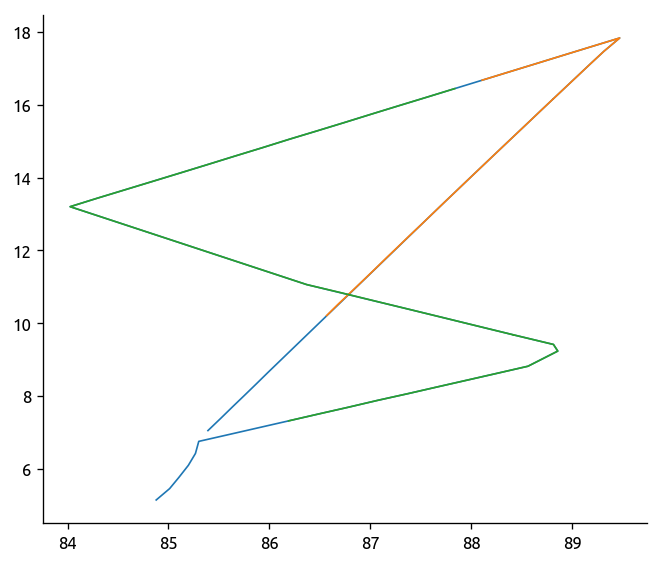

In [3]:
for tr in [tr3, tr1, tr2]:
    mask = tr['lon'] > 0
    plt.plot(tr['lon'][mask], tr['lat'][mask])

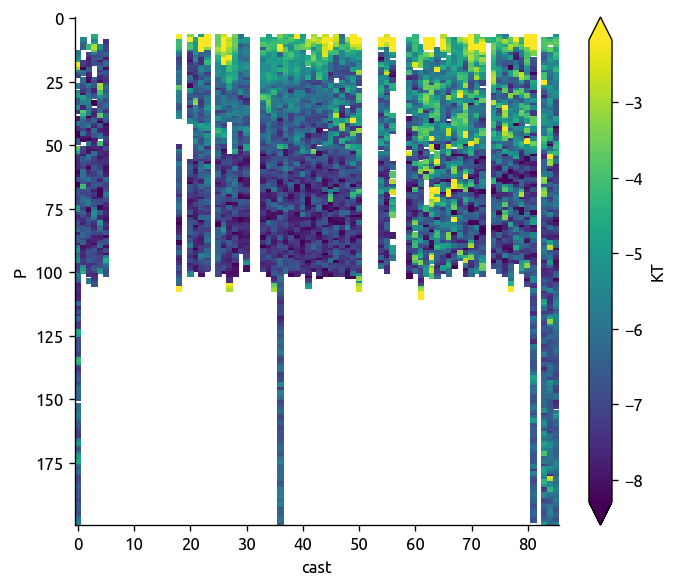

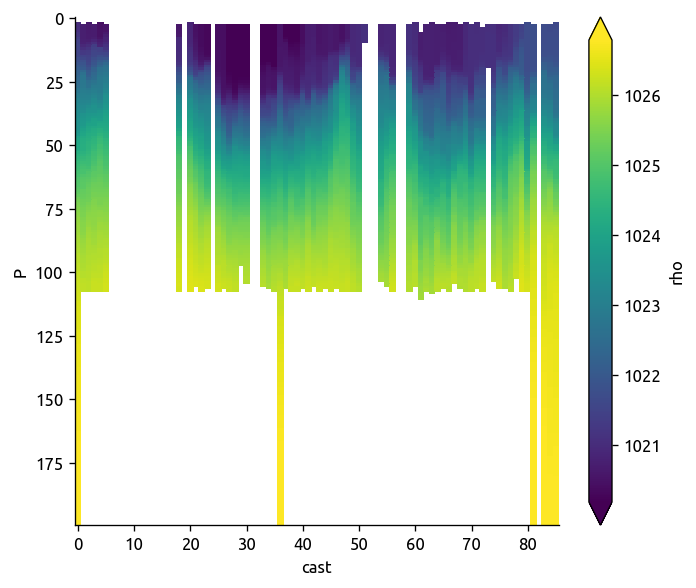

In [4]:
transect = xr.open_dataset('../datasets/bob-ctd-chipod/transect_3.nc')
np.log10(transect['KT']).plot(robust=True, yincrease=False)

plt.figure()
transect['rho'].plot(robust=True, yincrease=False)

# Read in gradients

In [6]:
argo = xr.open_dataset('../datasets/argo_clim_iso_gradients.nc', 
                       decode_times=False, autoclose=True).load()

ecco = xr.open_dataset('../datasets/ecco_annual_iso_gradient.nc', 
                       autoclose=True).load()

(array([  95.,  126.,  344.,  737., 2068., 2364., 2329., 2180., 1944.,
         715.]),
 array([1017.64768426, 1018.40508361, 1019.16248295, 1019.91988229,
        1020.67728163, 1021.43468097, 1022.19208032, 1022.94947966,
        1023.706879  , 1024.46427834, 1025.22167769]),
 <a list of 10 Patch objects>)

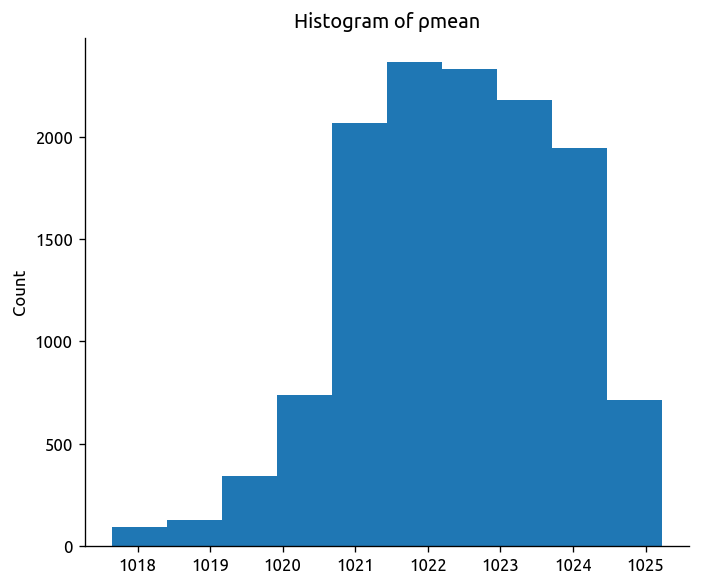

In [7]:
region={'lat': slice(4,24), 
        'lon': slice(72, 96),
       'pres': slice(0,100)}
ecco.ρmean.sel(**region).plot()

\begin{equation}
    K_e = \frac{⟨\widetilde{χ}⟩/2 - ⟨K_T \, ∂_z \widetilde{θ}⟩ \; ∂_z θ_m}{|∇θ_m|²}
\end{equation}

In [12]:
def get_region_from_transect(transect):
    return {'lon': slice(transect.lon.min(), transect.lon.max()),
            'lat': slice(transect.lat.min(), transect.lat.max()),
            'pres': slice(transect.pres.min(),np.min([100, transect.pres.max()]))}


def average_transect(transect):
    # create dataframe for transect data
    trdf = (transect.drop(['eps', 'fspd', 'N2', 'T', 'S', 'theta', 'sigma'])
            .to_dataframe())
    trdf = (trdf
            .where(~np.isnan(trdf['KT']))
            .dropna(how='all')
            .reset_index())
    trdf['KtTz'] = trdf['KT'] * trdf['dTdz']

    ρinds, ρbins = pd.qcut(trdf.rho, 8, retbins=True)

    # means for transect
    trmean = trdf.groupby(ρinds).mean()
    
    return trmean, ρbins


def average_clim(field, transect, ρbins):
    region = get_region_from_transect(transect)

    clim = field.sel(**region)
    dTiso = clim.dTiso.sel(**region)
    # clim.ρmean.plot.hist(alpha=0.5)
    # transect.rho.plot.hist(alpha=0.5)

    climdf = clim.to_dataframe().reset_index()
    ρinds = pd.cut(climdf.ρmean, ρbins)
    climmean = climdf.groupby(ρinds).mean()
    
    return climmean


def estimate_Ke(trans, clim):
    Ke = (trans.chi/2 - trans.KtTz * clim.dTdia)/clim.dTiso**2
    
    return Ke
    
    
trmean, ρbins = average_transect(transect)
eccomean = average_clim(ecco, transect, ρbins)
argomean = average_clim(argo, transect, ρbins)

Ke = pd.DataFrame()
Ke['ecco'] = estimate_Ke(trmean, eccomean)
Ke['argo'] = estimate_Ke(trmean, argomean)
Ke['rho'] = ρbins

Ke

,ecco,argo,rho
"(1019.12, 1021.151]",NaN,NaN,1019.120811
"(1019.121, 1021.151]",NaN,NaN,1021.151417
"(1021.151, 1022.542]",1.733279e+06,2.680101e+06,1022.541600
"(1022.542, 1023.607]",5.671920e+06,2.431258e+05,1023.607289
"(1023.607, 1024.48]",1.783079e+07,2.310301e+05,1024.480046
"(1024.48, 1025.153]",7.148620e+06,NaN,1025.152582
"(1025.153, 1025.664]",NaN,NaN,1025.663500
"(1025.664, 1026.101]",NaN,NaN,1026.100747
"(1026.101, 1026.889]",NaN,NaN,1026.888904


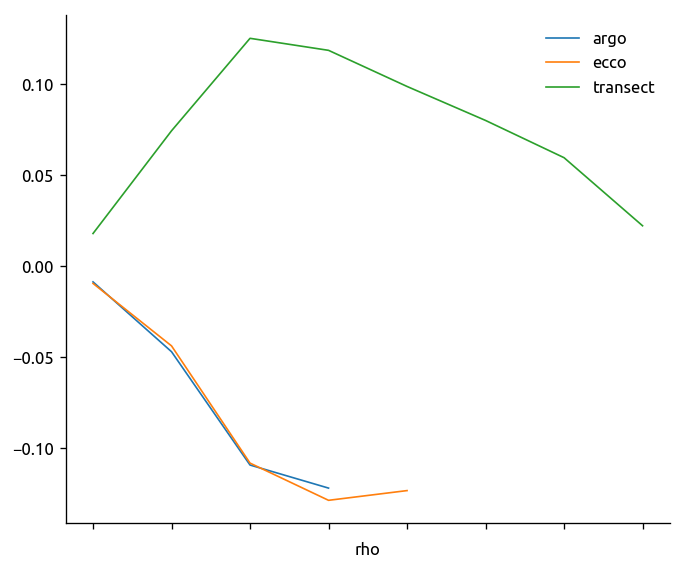

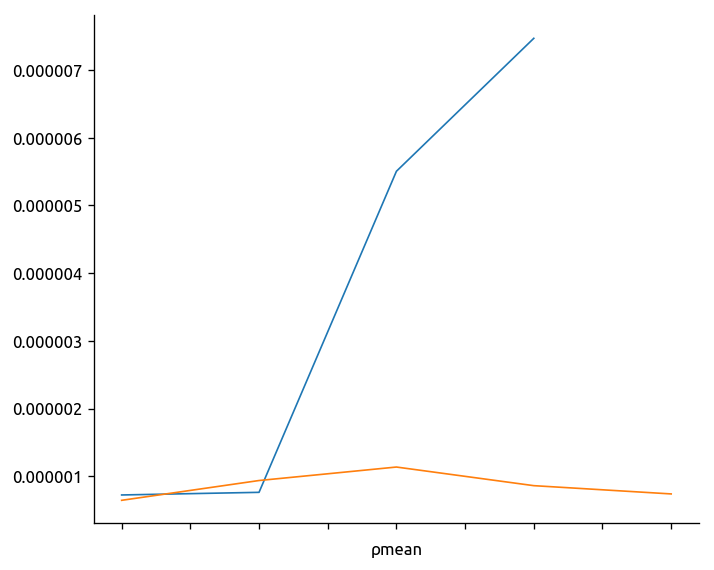

In [14]:
plt.figure()
argomean.dTdia.plot(x='rho')
eccomean.dTdia.plot(x='rho')
(trmean.dTdz).plot(x='rho')
plt.legend(['argo', 'ecco', 'transect'])

plt.figure()
argomean.dTiso.plot(x='rho')
eccomean.dTiso.plot(x='rho')

In [ ]:
ρbins.shape

In [ ]:
ecco

In [ ]:
%whos